In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [07:36:48] Enabling RDKit 2019.09.3 jupyter extensions
[07:36:48] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  8597


not successfully processed smiles:  [F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1


not successfully processed smiles:  [NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-]
not successfully processed smiles:  [Cl-][Pt]1([Cl-])[NH2+]CC[NH2+]1
not successfully processed smiles:  [Na+].[Na+].F[Si--](F)(F)(F)(F)F
not successfully processed smiles:  [NH4+].[NH4+].F[Si--](F)(F)(F)(F)F


not successfully processed smiles:  O.O.O.O.O=C1O[Mg]2(OC(=O)C3=CC=CC=C3O2)OC2=CC=CC=C12


not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL


not successfully processed smiles:  FAIL


not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL


not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL


not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
not successfully processed smiles:  FAIL
number of successfully processed smiles:  8576


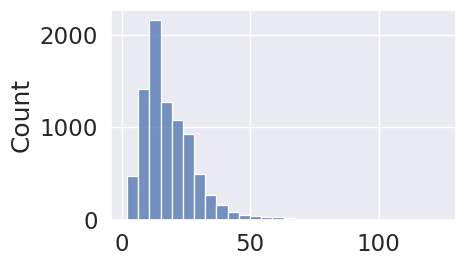

In [4]:
task_name = 'toxcast'
tasks = [
'ACEA_T47D_80hr_Negative','ACEA_T47D_80hr_Positive','APR_HepG2_CellCycleArrest_24h_dn','APR_HepG2_CellCycleArrest_24h_up','APR_HepG2_CellCycleArrest_72h_dn','APR_HepG2_CellLoss_24h_dn','APR_HepG2_CellLoss_72h_dn','APR_HepG2_MicrotubuleCSK_24h_dn','APR_HepG2_MicrotubuleCSK_24h_up','APR_HepG2_MicrotubuleCSK_72h_dn','APR_HepG2_MicrotubuleCSK_72h_up','APR_HepG2_MitoMass_24h_dn','APR_HepG2_MitoMass_24h_up','APR_HepG2_MitoMass_72h_dn','APR_HepG2_MitoMass_72h_up','APR_HepG2_MitoMembPot_1h_dn','APR_HepG2_MitoMembPot_24h_dn','APR_HepG2_MitoMembPot_72h_dn','APR_HepG2_MitoticArrest_24h_up','APR_HepG2_MitoticArrest_72h_up','APR_HepG2_NuclearSize_24h_dn','APR_HepG2_NuclearSize_72h_dn','APR_HepG2_NuclearSize_72h_up','APR_HepG2_OxidativeStress_24h_up','APR_HepG2_OxidativeStress_72h_up','APR_HepG2_StressKinase_1h_up','APR_HepG2_StressKinase_24h_up','APR_HepG2_StressKinase_72h_up','APR_HepG2_p53Act_24h_up','APR_HepG2_p53Act_72h_up','APR_Hepat_Apoptosis_24hr_up','APR_Hepat_Apoptosis_48hr_up','APR_Hepat_CellLoss_24hr_dn','APR_Hepat_CellLoss_48hr_dn','APR_Hepat_DNADamage_24hr_up','APR_Hepat_DNADamage_48hr_up','APR_Hepat_DNATexture_24hr_up','APR_Hepat_DNATexture_48hr_up','APR_Hepat_MitoFxnI_1hr_dn','APR_Hepat_MitoFxnI_24hr_dn','APR_Hepat_MitoFxnI_48hr_dn','APR_Hepat_NuclearSize_24hr_dn','APR_Hepat_NuclearSize_48hr_dn','APR_Hepat_Steatosis_24hr_up','APR_Hepat_Steatosis_48hr_up','ATG_AP_1_CIS_dn','ATG_AP_1_CIS_up','ATG_AP_2_CIS_dn','ATG_AP_2_CIS_up','ATG_AR_TRANS_dn','ATG_AR_TRANS_up','ATG_Ahr_CIS_dn','ATG_Ahr_CIS_up','ATG_BRE_CIS_dn','ATG_BRE_CIS_up','ATG_CAR_TRANS_dn','ATG_CAR_TRANS_up','ATG_CMV_CIS_dn','ATG_CMV_CIS_up','ATG_CRE_CIS_dn','ATG_CRE_CIS_up','ATG_C_EBP_CIS_dn','ATG_C_EBP_CIS_up','ATG_DR4_LXR_CIS_dn','ATG_DR4_LXR_CIS_up','ATG_DR5_CIS_dn','ATG_DR5_CIS_up','ATG_E2F_CIS_dn','ATG_E2F_CIS_up','ATG_EGR_CIS_up','ATG_ERE_CIS_dn','ATG_ERE_CIS_up','ATG_ERRa_TRANS_dn','ATG_ERRg_TRANS_dn','ATG_ERRg_TRANS_up','ATG_ERa_TRANS_up','ATG_E_Box_CIS_dn','ATG_E_Box_CIS_up','ATG_Ets_CIS_dn','ATG_Ets_CIS_up','ATG_FXR_TRANS_up','ATG_FoxA2_CIS_dn','ATG_FoxA2_CIS_up','ATG_FoxO_CIS_dn','ATG_FoxO_CIS_up','ATG_GAL4_TRANS_dn','ATG_GATA_CIS_dn','ATG_GATA_CIS_up','ATG_GLI_CIS_dn','ATG_GLI_CIS_up','ATG_GRE_CIS_dn','ATG_GRE_CIS_up','ATG_GR_TRANS_dn','ATG_GR_TRANS_up','ATG_HIF1a_CIS_dn','ATG_HIF1a_CIS_up','ATG_HNF4a_TRANS_dn','ATG_HNF4a_TRANS_up','ATG_HNF6_CIS_dn','ATG_HNF6_CIS_up','ATG_HSE_CIS_dn','ATG_HSE_CIS_up','ATG_IR1_CIS_dn','ATG_IR1_CIS_up','ATG_ISRE_CIS_dn','ATG_ISRE_CIS_up','ATG_LXRa_TRANS_dn','ATG_LXRa_TRANS_up','ATG_LXRb_TRANS_dn','ATG_LXRb_TRANS_up','ATG_MRE_CIS_up','ATG_M_06_TRANS_up','ATG_M_19_CIS_dn','ATG_M_19_TRANS_dn','ATG_M_19_TRANS_up','ATG_M_32_CIS_dn','ATG_M_32_CIS_up','ATG_M_32_TRANS_dn','ATG_M_32_TRANS_up','ATG_M_61_TRANS_up','ATG_Myb_CIS_dn','ATG_Myb_CIS_up','ATG_Myc_CIS_dn','ATG_Myc_CIS_up','ATG_NFI_CIS_dn','ATG_NFI_CIS_up','ATG_NF_kB_CIS_dn','ATG_NF_kB_CIS_up','ATG_NRF1_CIS_dn','ATG_NRF1_CIS_up','ATG_NRF2_ARE_CIS_dn','ATG_NRF2_ARE_CIS_up','ATG_NURR1_TRANS_dn','ATG_NURR1_TRANS_up','ATG_Oct_MLP_CIS_dn','ATG_Oct_MLP_CIS_up','ATG_PBREM_CIS_dn','ATG_PBREM_CIS_up','ATG_PPARa_TRANS_dn','ATG_PPARa_TRANS_up','ATG_PPARd_TRANS_up','ATG_PPARg_TRANS_up','ATG_PPRE_CIS_dn','ATG_PPRE_CIS_up','ATG_PXRE_CIS_dn','ATG_PXRE_CIS_up','ATG_PXR_TRANS_dn','ATG_PXR_TRANS_up','ATG_Pax6_CIS_up','ATG_RARa_TRANS_dn','ATG_RARa_TRANS_up','ATG_RARb_TRANS_dn','ATG_RARb_TRANS_up','ATG_RARg_TRANS_dn','ATG_RARg_TRANS_up','ATG_RORE_CIS_dn','ATG_RORE_CIS_up','ATG_RORb_TRANS_dn','ATG_RORg_TRANS_dn','ATG_RORg_TRANS_up','ATG_RXRa_TRANS_dn','ATG_RXRa_TRANS_up','ATG_RXRb_TRANS_dn','ATG_RXRb_TRANS_up','ATG_SREBP_CIS_dn','ATG_SREBP_CIS_up','ATG_STAT3_CIS_dn','ATG_STAT3_CIS_up','ATG_Sox_CIS_dn','ATG_Sox_CIS_up','ATG_Sp1_CIS_dn','ATG_Sp1_CIS_up','ATG_TAL_CIS_dn','ATG_TAL_CIS_up','ATG_TA_CIS_dn','ATG_TA_CIS_up','ATG_TCF_b_cat_CIS_dn','ATG_TCF_b_cat_CIS_up','ATG_TGFb_CIS_dn','ATG_TGFb_CIS_up','ATG_THRa1_TRANS_dn','ATG_THRa1_TRANS_up','ATG_VDRE_CIS_dn','ATG_VDRE_CIS_up','ATG_VDR_TRANS_dn','ATG_VDR_TRANS_up','ATG_XTT_Cytotoxicity_up','ATG_Xbp1_CIS_dn','ATG_Xbp1_CIS_up','ATG_p53_CIS_dn','ATG_p53_CIS_up','BSK_3C_Eselectin_down','BSK_3C_HLADR_down','BSK_3C_ICAM1_down','BSK_3C_IL8_down','BSK_3C_MCP1_down','BSK_3C_MIG_down','BSK_3C_Proliferation_down','BSK_3C_SRB_down','BSK_3C_Thrombomodulin_down','BSK_3C_Thrombomodulin_up','BSK_3C_TissueFactor_down','BSK_3C_TissueFactor_up','BSK_3C_VCAM1_down','BSK_3C_Vis_down','BSK_3C_uPAR_down','BSK_4H_Eotaxin3_down','BSK_4H_MCP1_down','BSK_4H_Pselectin_down','BSK_4H_Pselectin_up','BSK_4H_SRB_down','BSK_4H_VCAM1_down','BSK_4H_VEGFRII_down','BSK_4H_uPAR_down','BSK_4H_uPAR_up','BSK_BE3C_HLADR_down','BSK_BE3C_IL1a_down','BSK_BE3C_IP10_down','BSK_BE3C_MIG_down','BSK_BE3C_MMP1_down','BSK_BE3C_MMP1_up','BSK_BE3C_PAI1_down','BSK_BE3C_SRB_down','BSK_BE3C_TGFb1_down','BSK_BE3C_tPA_down','BSK_BE3C_uPAR_down','BSK_BE3C_uPAR_up','BSK_BE3C_uPA_down','BSK_CASM3C_HLADR_down','BSK_CASM3C_IL6_down','BSK_CASM3C_IL6_up','BSK_CASM3C_IL8_down','BSK_CASM3C_LDLR_down','BSK_CASM3C_LDLR_up','BSK_CASM3C_MCP1_down','BSK_CASM3C_MCP1_up','BSK_CASM3C_MCSF_down','BSK_CASM3C_MCSF_up','BSK_CASM3C_MIG_down','BSK_CASM3C_Proliferation_down','BSK_CASM3C_Proliferation_up','BSK_CASM3C_SAA_down','BSK_CASM3C_SAA_up','BSK_CASM3C_SRB_down','BSK_CASM3C_Thrombomodulin_down','BSK_CASM3C_Thrombomodulin_up','BSK_CASM3C_TissueFactor_down','BSK_CASM3C_VCAM1_down','BSK_CASM3C_VCAM1_up','BSK_CASM3C_uPAR_down','BSK_CASM3C_uPAR_up','BSK_KF3CT_ICAM1_down','BSK_KF3CT_IL1a_down','BSK_KF3CT_IP10_down','BSK_KF3CT_IP10_up','BSK_KF3CT_MCP1_down','BSK_KF3CT_MCP1_up','BSK_KF3CT_MMP9_down','BSK_KF3CT_SRB_down','BSK_KF3CT_TGFb1_down','BSK_KF3CT_TIMP2_down','BSK_KF3CT_uPA_down','BSK_LPS_CD40_down','BSK_LPS_Eselectin_down','BSK_LPS_Eselectin_up','BSK_LPS_IL1a_down','BSK_LPS_IL1a_up','BSK_LPS_IL8_down','BSK_LPS_IL8_up','BSK_LPS_MCP1_down','BSK_LPS_MCSF_down','BSK_LPS_PGE2_down','BSK_LPS_PGE2_up','BSK_LPS_SRB_down','BSK_LPS_TNFa_down','BSK_LPS_TNFa_up','BSK_LPS_TissueFactor_down','BSK_LPS_TissueFactor_up','BSK_LPS_VCAM1_down','BSK_SAg_CD38_down','BSK_SAg_CD40_down','BSK_SAg_CD69_down','BSK_SAg_Eselectin_down','BSK_SAg_Eselectin_up','BSK_SAg_IL8_down','BSK_SAg_IL8_up','BSK_SAg_MCP1_down','BSK_SAg_MIG_down','BSK_SAg_PBMCCytotoxicity_down','BSK_SAg_PBMCCytotoxicity_up','BSK_SAg_Proliferation_down','BSK_SAg_SRB_down','BSK_hDFCGF_CollagenIII_down','BSK_hDFCGF_EGFR_down','BSK_hDFCGF_EGFR_up','BSK_hDFCGF_IL8_down','BSK_hDFCGF_IP10_down','BSK_hDFCGF_MCSF_down','BSK_hDFCGF_MIG_down','BSK_hDFCGF_MMP1_down','BSK_hDFCGF_MMP1_up','BSK_hDFCGF_PAI1_down','BSK_hDFCGF_Proliferation_down','BSK_hDFCGF_SRB_down','BSK_hDFCGF_TIMP1_down','BSK_hDFCGF_VCAM1_down','CEETOX_H295R_11DCORT_dn','CEETOX_H295R_ANDR_dn','CEETOX_H295R_CORTISOL_dn','CEETOX_H295R_DOC_dn','CEETOX_H295R_DOC_up','CEETOX_H295R_ESTRADIOL_dn','CEETOX_H295R_ESTRADIOL_up','CEETOX_H295R_ESTRONE_dn','CEETOX_H295R_ESTRONE_up','CEETOX_H295R_OHPREG_up','CEETOX_H295R_OHPROG_dn','CEETOX_H295R_OHPROG_up','CEETOX_H295R_PROG_up','CEETOX_H295R_TESTO_dn','CLD_ABCB1_48hr','CLD_ABCG2_48hr','CLD_CYP1A1_24hr','CLD_CYP1A1_48hr','CLD_CYP1A1_6hr','CLD_CYP1A2_24hr','CLD_CYP1A2_48hr','CLD_CYP1A2_6hr','CLD_CYP2B6_24hr','CLD_CYP2B6_48hr','CLD_CYP2B6_6hr','CLD_CYP3A4_24hr','CLD_CYP3A4_48hr','CLD_CYP3A4_6hr','CLD_GSTA2_48hr','CLD_SULT2A_24hr','CLD_SULT2A_48hr','CLD_UGT1A1_24hr','CLD_UGT1A1_48hr','NCCT_HEK293T_CellTiterGLO','NCCT_QuantiLum_inhib_2_dn','NCCT_QuantiLum_inhib_dn','NCCT_TPO_AUR_dn','NCCT_TPO_GUA_dn','NHEERL_ZF_144hpf_TERATOSCORE_up','NVS_ADME_hCYP19A1','NVS_ADME_hCYP1A1','NVS_ADME_hCYP1A2','NVS_ADME_hCYP2A6','NVS_ADME_hCYP2B6','NVS_ADME_hCYP2C19','NVS_ADME_hCYP2C9','NVS_ADME_hCYP2D6','NVS_ADME_hCYP3A4','NVS_ADME_hCYP4F12','NVS_ADME_rCYP2C12','NVS_ENZ_hAChE','NVS_ENZ_hAMPKa1','NVS_ENZ_hAurA','NVS_ENZ_hBACE','NVS_ENZ_hCASP5','NVS_ENZ_hCK1D','NVS_ENZ_hDUSP3','NVS_ENZ_hES','NVS_ENZ_hElastase','NVS_ENZ_hFGFR1','NVS_ENZ_hGSK3b','NVS_ENZ_hMMP1','NVS_ENZ_hMMP13','NVS_ENZ_hMMP2','NVS_ENZ_hMMP3','NVS_ENZ_hMMP7','NVS_ENZ_hMMP9','NVS_ENZ_hPDE10','NVS_ENZ_hPDE4A1','NVS_ENZ_hPDE5','NVS_ENZ_hPI3Ka','NVS_ENZ_hPTEN','NVS_ENZ_hPTPN11','NVS_ENZ_hPTPN12','NVS_ENZ_hPTPN13','NVS_ENZ_hPTPN9','NVS_ENZ_hPTPRC','NVS_ENZ_hSIRT1','NVS_ENZ_hSIRT2','NVS_ENZ_hTrkA','NVS_ENZ_hVEGFR2','NVS_ENZ_oCOX1','NVS_ENZ_oCOX2','NVS_ENZ_rAChE','NVS_ENZ_rCNOS','NVS_ENZ_rMAOAC','NVS_ENZ_rMAOAP','NVS_ENZ_rMAOBC','NVS_ENZ_rMAOBP','NVS_ENZ_rabI2C','NVS_GPCR_bAdoR_NonSelective','NVS_GPCR_bDR_NonSelective','NVS_GPCR_g5HT4','NVS_GPCR_gH2','NVS_GPCR_gLTB4','NVS_GPCR_gLTD4','NVS_GPCR_gMPeripheral_NonSelective','NVS_GPCR_gOpiateK','NVS_GPCR_h5HT2A','NVS_GPCR_h5HT5A','NVS_GPCR_h5HT6','NVS_GPCR_h5HT7','NVS_GPCR_hAT1','NVS_GPCR_hAdoRA1','NVS_GPCR_hAdoRA2a','NVS_GPCR_hAdra2A','NVS_GPCR_hAdra2C','NVS_GPCR_hAdrb1','NVS_GPCR_hAdrb2','NVS_GPCR_hAdrb3','NVS_GPCR_hDRD1','NVS_GPCR_hDRD2s','NVS_GPCR_hDRD4.4','NVS_GPCR_hH1','NVS_GPCR_hLTB4_BLT1','NVS_GPCR_hM1','NVS_GPCR_hM2','NVS_GPCR_hM3','NVS_GPCR_hM4','NVS_GPCR_hNK2','NVS_GPCR_hOpiate_D1','NVS_GPCR_hOpiate_mu','NVS_GPCR_hTXA2','NVS_GPCR_p5HT2C','NVS_GPCR_r5HT1_NonSelective','NVS_GPCR_r5HT_NonSelective','NVS_GPCR_rAdra1B','NVS_GPCR_rAdra1_NonSelective','NVS_GPCR_rAdra2_NonSelective','NVS_GPCR_rAdrb_NonSelective','NVS_GPCR_rNK1','NVS_GPCR_rNK3','NVS_GPCR_rOpiate_NonSelective','NVS_GPCR_rOpiate_NonSelectiveNa','NVS_GPCR_rSST','NVS_GPCR_rTRH','NVS_GPCR_rV1','NVS_GPCR_rabPAF','NVS_GPCR_rmAdra2B','NVS_IC_hKhERGCh','NVS_IC_rCaBTZCHL','NVS_IC_rCaDHPRCh_L','NVS_IC_rNaCh_site2','NVS_LGIC_bGABARa1','NVS_LGIC_h5HT3','NVS_LGIC_hNNR_NBungSens','NVS_LGIC_rGABAR_NonSelective','NVS_LGIC_rNNR_BungSens','NVS_MP_hPBR','NVS_MP_rPBR','NVS_NR_bER','NVS_NR_bPR','NVS_NR_cAR','NVS_NR_hAR','NVS_NR_hCAR_Antagonist','NVS_NR_hER','NVS_NR_hFXR_Agonist','NVS_NR_hFXR_Antagonist','NVS_NR_hGR','NVS_NR_hPPARa','NVS_NR_hPPARg','NVS_NR_hPR','NVS_NR_hPXR','NVS_NR_hRAR_Antagonist','NVS_NR_hRARa_Agonist','NVS_NR_hTRa_Antagonist','NVS_NR_mERa','NVS_NR_rAR','NVS_NR_rMR','NVS_OR_gSIGMA_NonSelective','NVS_TR_gDAT','NVS_TR_hAdoT','NVS_TR_hDAT','NVS_TR_hNET','NVS_TR_hSERT','NVS_TR_rNET','NVS_TR_rSERT','NVS_TR_rVMAT2','OT_AR_ARELUC_AG_1440','OT_AR_ARSRC1_0480','OT_AR_ARSRC1_0960','OT_ER_ERaERa_0480','OT_ER_ERaERa_1440','OT_ER_ERaERb_0480','OT_ER_ERaERb_1440','OT_ER_ERbERb_0480','OT_ER_ERbERb_1440','OT_ERa_EREGFP_0120','OT_ERa_EREGFP_0480','OT_FXR_FXRSRC1_0480','OT_FXR_FXRSRC1_1440','OT_NURR1_NURR1RXRa_0480','OT_NURR1_NURR1RXRa_1440','TOX21_ARE_BLA_Agonist_ch1','TOX21_ARE_BLA_Agonist_ch2','TOX21_ARE_BLA_agonist_ratio','TOX21_ARE_BLA_agonist_viability','TOX21_AR_BLA_Agonist_ch1','TOX21_AR_BLA_Agonist_ch2','TOX21_AR_BLA_Agonist_ratio','TOX21_AR_BLA_Antagonist_ch1','TOX21_AR_BLA_Antagonist_ch2','TOX21_AR_BLA_Antagonist_ratio','TOX21_AR_BLA_Antagonist_viability','TOX21_AR_LUC_MDAKB2_Agonist','TOX21_AR_LUC_MDAKB2_Antagonist','TOX21_AR_LUC_MDAKB2_Antagonist2','TOX21_AhR_LUC_Agonist','TOX21_Aromatase_Inhibition','TOX21_AutoFluor_HEK293_Cell_blue','TOX21_AutoFluor_HEK293_Media_blue','TOX21_AutoFluor_HEPG2_Cell_blue','TOX21_AutoFluor_HEPG2_Cell_green','TOX21_AutoFluor_HEPG2_Media_blue','TOX21_AutoFluor_HEPG2_Media_green','TOX21_ELG1_LUC_Agonist','TOX21_ERa_BLA_Agonist_ch1','TOX21_ERa_BLA_Agonist_ch2','TOX21_ERa_BLA_Agonist_ratio','TOX21_ERa_BLA_Antagonist_ch1','TOX21_ERa_BLA_Antagonist_ch2','TOX21_ERa_BLA_Antagonist_ratio','TOX21_ERa_BLA_Antagonist_viability','TOX21_ERa_LUC_BG1_Agonist','TOX21_ERa_LUC_BG1_Antagonist','TOX21_ESRE_BLA_ch1','TOX21_ESRE_BLA_ch2','TOX21_ESRE_BLA_ratio','TOX21_ESRE_BLA_viability','TOX21_FXR_BLA_Antagonist_ch1','TOX21_FXR_BLA_Antagonist_ch2','TOX21_FXR_BLA_agonist_ch2','TOX21_FXR_BLA_agonist_ratio','TOX21_FXR_BLA_antagonist_ratio','TOX21_FXR_BLA_antagonist_viability','TOX21_GR_BLA_Agonist_ch1','TOX21_GR_BLA_Agonist_ch2','TOX21_GR_BLA_Agonist_ratio','TOX21_GR_BLA_Antagonist_ch2','TOX21_GR_BLA_Antagonist_ratio','TOX21_GR_BLA_Antagonist_viability','TOX21_HSE_BLA_agonist_ch1','TOX21_HSE_BLA_agonist_ch2','TOX21_HSE_BLA_agonist_ratio','TOX21_HSE_BLA_agonist_viability','TOX21_MMP_ratio_down','TOX21_MMP_ratio_up','TOX21_MMP_viability','TOX21_NFkB_BLA_agonist_ch1','TOX21_NFkB_BLA_agonist_ch2','TOX21_NFkB_BLA_agonist_ratio','TOX21_NFkB_BLA_agonist_viability','TOX21_PPARd_BLA_Agonist_viability','TOX21_PPARd_BLA_Antagonist_ch1','TOX21_PPARd_BLA_agonist_ch1','TOX21_PPARd_BLA_agonist_ch2','TOX21_PPARd_BLA_agonist_ratio','TOX21_PPARd_BLA_antagonist_ratio','TOX21_PPARd_BLA_antagonist_viability','TOX21_PPARg_BLA_Agonist_ch1','TOX21_PPARg_BLA_Agonist_ch2','TOX21_PPARg_BLA_Agonist_ratio','TOX21_PPARg_BLA_Antagonist_ch1','TOX21_PPARg_BLA_antagonist_ratio','TOX21_PPARg_BLA_antagonist_viability','TOX21_TR_LUC_GH3_Agonist','TOX21_TR_LUC_GH3_Antagonist','TOX21_VDR_BLA_Agonist_viability','TOX21_VDR_BLA_Antagonist_ch1','TOX21_VDR_BLA_agonist_ch2','TOX21_VDR_BLA_agonist_ratio','TOX21_VDR_BLA_antagonist_ratio','TOX21_VDR_BLA_antagonist_viability','TOX21_p53_BLA_p1_ch1','TOX21_p53_BLA_p1_ch2','TOX21_p53_BLA_p1_ratio','TOX21_p53_BLA_p1_viability','TOX21_p53_BLA_p2_ch1','TOX21_p53_BLA_p2_ch2','TOX21_p53_BLA_p2_ratio','TOX21_p53_BLA_p2_viability','TOX21_p53_BLA_p3_ch1','TOX21_p53_BLA_p3_ch2','TOX21_p53_BLA_p3_ratio','TOX21_p53_BLA_p3_viability','TOX21_p53_BLA_p4_ch1','TOX21_p53_BLA_p4_ch2','TOX21_p53_BLA_p4_ratio','TOX21_p53_BLA_p4_viability','TOX21_p53_BLA_p5_ch1','TOX21_p53_BLA_p5_ch2','TOX21_p53_BLA_p5_ratio','TOX21_p53_BLA_p5_viability','Tanguay_ZF_120hpf_AXIS_up','Tanguay_ZF_120hpf_ActivityScore','Tanguay_ZF_120hpf_BRAI_up','Tanguay_ZF_120hpf_CFIN_up','Tanguay_ZF_120hpf_CIRC_up','Tanguay_ZF_120hpf_EYE_up','Tanguay_ZF_120hpf_JAW_up','Tanguay_ZF_120hpf_MORT_up','Tanguay_ZF_120hpf_OTIC_up','Tanguay_ZF_120hpf_PE_up','Tanguay_ZF_120hpf_PFIN_up','Tanguay_ZF_120hpf_PIG_up','Tanguay_ZF_120hpf_SNOU_up','Tanguay_ZF_120hpf_SOMI_up','Tanguay_ZF_120hpf_SWIM_up','Tanguay_ZF_120hpf_TRUN_up','Tanguay_ZF_120hpf_TR_up','Tanguay_ZF_120hpf_YSE_up'
]
raw_filename = "../data/toxcast_data.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[Ca+2].[Cl-].[Cl-]


[Cd+2].[Cl-].[Cl-]


CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F


O.O.[Ba+2].[Cl-].[Cl-]


CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F


N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]


CCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCC[n+]1ccccc1.F[P-](F)(F)(F)(F)F


CCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F


CCn1cc[n+](C)c1C.F[P-](F)(F)(F)(F)F


CCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F


CCCC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC.F[P-](F)(F)(F)(F)F


CCCC[n+]1ccc(C)cc1.F[P-](F)(F)(F)(F)F


[Cl-].[Cl-].[Cu+2]


[Cl-].[Cl-].[Hg+2]


[Br-].[Na+]


[I-].[K+]


[Cl-].[Cl-].[Cl-].[Fe+3]


[Cl-].[Cl-].[Fe+2]


[Cl-].[Cl-].[SnH2+2]


[Hg+2].[I-].[I-]


CCCCCC[n+]1ccccc1.F[P-](F)(F)(F)(F)F


CCCC[n+]1cccc(C)c1.F[P-](F)(F)(F)(F)F


CCCC[N+]1(C)CCCCC1.F[P-](F)(F)(F)(F)F


CCC[N+]1(C)CCCCC1.F[P-](F)(F)(F)(F)F


CCCC[n+]1ccccc1C.F[P-](F)(F)(F)(F)F


feature dicts file saved as ../data/toxcast_data.pickle


,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,cano_smiles
47,[Cl-].[Cl-].[Ca++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Ca+2].[Cl-].[Cl-]
93,[Cl-].[Cl-].[Cd++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Cd+2].[Cl-].[Cl-]
213,F[P-](F)(F)(F)(F)F.CC[N+]1=CC=CC=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
220,O.O.[Cl-].[Cl-].[Ba++],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O.O.[Ba+2].[Cl-].[Cl-]
1203,F[P-](F)(F)(F)(F)F.CC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC[N+]1(C)CCCC1.F[P-](F)(F)(F)(F)F
1777,O.O.[Na+].[Na+].O=N[Fe--](C#N)(C#N)(C#N)(C#N)C#N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]
2259,F[P-](F)(F)(F)(F)F.CCN1C=C[N+](C)=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
2532,F[P-](F)(F)(F)(F)F.CCCCN1C=C[N+](C)=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F
2676,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCC[n+]1ccccc1.F[P-](F)(F)(F)(F)F
2983,F[P-](F)(F)(F)(F)F.CCCN1C=C[N+](C)=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F


In [7]:
weights = []
positive_dist = []
negative_dist = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["cano_smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["cano_smiles",task]]
    try:
        weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                        (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    except:
        weights.append([1,1])
        
#     print(positive_test.shape[0],negative_test.shape[0])

    negative_dist.append(negative_df.shape[0])
    positive_dist.append(positive_df.shape[0])
    if len(negative_df)!=0:
        negative_test = negative_df.sample(frac=0.1,random_state=68)
        negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=68)
        negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    else:
        negative_test = negative_df
        negative_valid = negative_df
        negative_train = negative_df
        
    if len(positive_df)!=0:
        positive_test = positive_df.sample(frac=0.1,random_state=68)
        positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=68)
        positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    else:
        positive_test = positive_df
        positive_valid = positive_df
        positive_train = positive_df
    
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])
    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='cano_smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='cano_smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='cano_smiles', how='outer')
        

In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1393238
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc_mean:0.5060436543119216
valid_roc_mean:0.5063180871386952



EPOCH:	1
train_roc_mean:0.6033536758378992
valid_roc_mean:0.5922146665154835



EPOCH:	2
train_roc_mean:0.651854111946982
valid_roc_mean:0.6381898416253031



EPOCH:	3
train_roc_mean:0.6751971343767476
valid_roc_mean:0.6597515498651603



EPOCH:	4
train_roc_mean:0.6883314591692459
valid_roc_mean:0.6725047417254667



EPOCH:	5
train_roc_mean:0.6996244661730308
valid_roc_mean:0.6826263072739995



EPOCH:	6
train_roc_mean:0.7094832887649998
valid_roc_mean:0.6895034870582579



EPOCH:	7
train_roc_mean:0.7187345460306269
valid_roc_mean:0.6983096200089647



EPOCH:	8
train_roc_mean:0.7236846956931489
valid_roc_mean:0.7040156809572297



EPOCH:	9
train_roc_mean:0.7300017702259097
valid_roc_mean:0.7065093614125139



EPOCH:	10
train_roc_mean:0.7419129760530592
valid_roc_mean:0.7159692935538006



EPOCH:	11
train_roc_mean:0.7461784456719462
valid_roc_mean:0.7189876215460171



EPOCH:	12
train_roc_mean:0.7562724773550409
valid_roc_mean:0.7271753890238728



EPOCH:	13
train_roc_mean:0.7651191115987657
valid_roc_mean:0.736064910246036



EPOCH:	14
train_roc_mean:0.7693587274209349
valid_roc_mean:0.74004087191165



EPOCH:	15
train_roc_mean:0.7805748935836081
valid_roc_mean:0.7478207151744293



EPOCH:	16
train_roc_mean:0.7883827815093627
valid_roc_mean:0.7532024107071966



EPOCH:	17
train_roc_mean:0.7899643727484491
valid_roc_mean:0.756545214699955



EPOCH:	18
train_roc_mean:0.7974952127366927
valid_roc_mean:0.7604045947079296



EPOCH:	19
train_roc_mean:0.8016080897474903
valid_roc_mean:0.7616903301675986



EPOCH:	20
train_roc_mean:0.8065328946668381
valid_roc_mean:0.7665432553529672



EPOCH:	21
train_roc_mean:0.8091302085566682
valid_roc_mean:0.7663897376307075



EPOCH:	22
train_roc_mean:0.8159081979214209
valid_roc_mean:0.7694664674367712



EPOCH:	23
train_roc_mean:0.8199865612903405
valid_roc_mean:0.7732387117657994



EPOCH:	24
train_roc_mean:0.8244572567416159
valid_roc_mean:0.7731239623999214



EPOCH:	25
train_roc_mean:0.826875241205207
valid_roc_mean:0.7758913261704014



EPOCH:	26
train_roc_mean:0.834215338592553
valid_roc_mean:0.7775285097950122



EPOCH:	27
train_roc_mean:0.837914260801116
valid_roc_mean:0.7800453427777794



EPOCH:	28
train_roc_mean:0.8364959588315065
valid_roc_mean:0.7797327540452446



EPOCH:	29
train_roc_mean:0.8429720281012117
valid_roc_mean:0.7813694655144204



EPOCH:	30
train_roc_mean:0.8493436133279003
valid_roc_mean:0.7832495186517173



EPOCH:	31
train_roc_mean:0.8509964285286672
valid_roc_mean:0.786230267630577



EPOCH:	32
train_roc_mean:0.8545880356011125
valid_roc_mean:0.7867308229191808



EPOCH:	33
train_roc_mean:0.8567282883572098
valid_roc_mean:0.7832013525659395



EPOCH:	34
train_roc_mean:0.861447582429784
valid_roc_mean:0.7907430777534449



EPOCH:	35
train_roc_mean:0.8640440022940838
valid_roc_mean:0.7863557111172492



EPOCH:	36
train_roc_mean:0.8685384347232838
valid_roc_mean:0.7882238975872943



EPOCH:	37
train_roc_mean:0.870298427349737
valid_roc_mean:0.7927555697336639



EPOCH:	38
train_roc_mean:0.866685450991629
valid_roc_mean:0.7895554742320258



EPOCH:	39
train_roc_mean:0.875554323936051
valid_roc_mean:0.7940581851356021



EPOCH:	40
train_roc_mean:0.879492183623428
valid_roc_mean:0.7946905272073219



EPOCH:	41
train_roc_mean:0.8808781751402294
valid_roc_mean:0.7923207310629622



EPOCH:	42
train_roc_mean:0.8844775920628617
valid_roc_mean:0.7958600212868473



EPOCH:	43
train_roc_mean:0.8837881523730752
valid_roc_mean:0.7939604826590269



EPOCH:	44
train_roc_mean:0.8889735650540855
valid_roc_mean:0.79716596731197



EPOCH:	45
train_roc_mean:0.8917727058755317
valid_roc_mean:0.7982970944848761



EPOCH:	46
train_roc_mean:0.8938727217087123
valid_roc_mean:0.8005516624033332



EPOCH:	47
train_roc_mean:0.8964820235811308
valid_roc_mean:0.801359893360246



EPOCH:	48
train_roc_mean:0.8975954503149518
valid_roc_mean:0.7971420165403512



EPOCH:	49
train_roc_mean:0.9012134472603941
valid_roc_mean:0.8001109163100907



EPOCH:	50
train_roc_mean:0.902246742426875
valid_roc_mean:0.8049171323731514



EPOCH:	51
train_roc_mean:0.9046349366078552
valid_roc_mean:0.8034141516916465



EPOCH:	52
train_roc_mean:0.9055743634562167
valid_roc_mean:0.8040708936302056



EPOCH:	53
train_roc_mean:0.9075158931902141
valid_roc_mean:0.8010762124669102



EPOCH:	54
train_roc_mean:0.9093448495384542
valid_roc_mean:0.8014404427993504



EPOCH:	55
train_roc_mean:0.9120705285046796
valid_roc_mean:0.805780367094276



EPOCH:	56
train_roc_mean:0.9137610048817191
valid_roc_mean:0.8071826661368643



EPOCH:	57
train_roc_mean:0.9161085559945152
valid_roc_mean:0.8068853595103973



EPOCH:	58
train_roc_mean:0.9176967929604327
valid_roc_mean:0.8065753596233283



EPOCH:	59
train_roc_mean:0.9182705689986362
valid_roc_mean:0.8081060535333398



EPOCH:	60
train_roc_mean:0.9205580301045335
valid_roc_mean:0.8084702281641793



EPOCH:	61
train_roc_mean:0.9218261023571429
valid_roc_mean:0.8092735668683819



EPOCH:	62
train_roc_mean:0.9217874749959246
valid_roc_mean:0.8112489808747776



EPOCH:	63
train_roc_mean:0.9241800194474982
valid_roc_mean:0.811744014921508



EPOCH:	64
train_roc_mean:0.9251834536151594
valid_roc_mean:0.8107456357198242



EPOCH:	65
train_roc_mean:0.9269743557403624
valid_roc_mean:0.8116111061238432



EPOCH:	66
train_roc_mean:0.9292338628547983
valid_roc_mean:0.8123822472009938



EPOCH:	67
train_roc_mean:0.9296929576099726
valid_roc_mean:0.8103706136828671



EPOCH:	68
train_roc_mean:0.9308102611579911
valid_roc_mean:0.812611770536943



EPOCH:	69
train_roc_mean:0.9323983222295431
valid_roc_mean:0.8126756703166476



EPOCH:	70
train_roc_mean:0.9335751112731745
valid_roc_mean:0.8166273408880665



EPOCH:	71
train_roc_mean:0.9347766763981122
valid_roc_mean:0.8140924521552453



EPOCH:	72
train_roc_mean:0.933820814837567
valid_roc_mean:0.8136387153118003



EPOCH:	73
train_roc_mean:0.9353294459973457
valid_roc_mean:0.8132939833015747



EPOCH:	74
train_roc_mean:0.9373897411839422
valid_roc_mean:0.8150127421864718



EPOCH:	75
train_roc_mean:0.9379024148528455
valid_roc_mean:0.813511414015592



EPOCH:	76
train_roc_mean:0.9386502033312885
valid_roc_mean:0.8133550305162072



EPOCH:	77
train_roc_mean:0.9398810282529775
valid_roc_mean:0.8126116209568394



EPOCH:	78
train_roc_mean:0.9409050201054169
valid_roc_mean:0.8159077127051583



EPOCH:	79
train_roc_mean:0.9418609183182195
valid_roc_mean:0.8145134025118083



EPOCH:	80
train_roc_mean:0.9424273544565409
valid_roc_mean:0.8164356854087101



EPOCH:	81
train_roc_mean:0.9419026536184768
valid_roc_mean:0.8126947681414348



EPOCH:	82
train_roc_mean:0.9440624972505113
valid_roc_mean:0.8162153179254443



EPOCH:	83
train_roc_mean:0.9441593345469087
valid_roc_mean:0.8163484063970227



EPOCH:	84
train_roc_mean:0.9455777876558448
valid_roc_mean:0.8185631262611541



EPOCH:	85
train_roc_mean:0.9469043860939312
valid_roc_mean:0.816596113031332



EPOCH:	86
train_roc_mean:0.9473598942130969
valid_roc_mean:0.81823898645126



EPOCH:	87
train_roc_mean:0.9469505092110804
valid_roc_mean:0.8157357049527958



EPOCH:	88
train_roc_mean:0.9482627461224341
valid_roc_mean:0.8149425766287731



EPOCH:	89
train_roc_mean:0.9490895491621691
valid_roc_mean:0.8173713604083936



EPOCH:	90
train_roc_mean:0.9494562174416382
valid_roc_mean:0.8180524909088603



EPOCH:	91
train_roc_mean:0.9505052053430938
valid_roc_mean:0.8172334456540835



EPOCH:	92
train_roc_mean:0.9503023088307735
valid_roc_mean:0.8157984657412246



EPOCH:	93
train_roc_mean:0.9513172803285047
valid_roc_mean:0.820424954091994



EPOCH:	94
train_roc_mean:0.9514789954768651
valid_roc_mean:0.8202919309317035



EPOCH:	95
train_roc_mean:0.9525360970607443
valid_roc_mean:0.8168697598003282



EPOCH:	96
train_roc_mean:0.9532393055890468
valid_roc_mean:0.819159739324193



EPOCH:	97
train_roc_mean:0.9537926540082119
valid_roc_mean:0.818065807677631



EPOCH:	98
train_roc_mean:0.9542312680306378
valid_roc_mean:0.8192285797304326



EPOCH:	99
train_roc_mean:0.9542027782975088
valid_roc_mean:0.8202816025887413



EPOCH:	100
train_roc_mean:0.9552827404241232
valid_roc_mean:0.8216005969731734



EPOCH:	101
train_roc_mean:0.9547507163864088
valid_roc_mean:0.8201842810361185



EPOCH:	102
train_roc_mean:0.9551506716994379
valid_roc_mean:0.8201966144850829



EPOCH:	103
train_roc_mean:0.9562169361319063
valid_roc_mean:0.821120177232806



EPOCH:	104
train_roc_mean:0.9572227954972544
valid_roc_mean:0.8225155443624205



EPOCH:	105
train_roc_mean:0.957346575565762
valid_roc_mean:0.8217309916886272



EPOCH:	106
train_roc_mean:0.9580939648375273
valid_roc_mean:0.8225661738016026



EPOCH:	107
train_roc_mean:0.9580532871061692
valid_roc_mean:0.8216700177090647



EPOCH:	108
train_roc_mean:0.9583322412756201
valid_roc_mean:0.8225370502983113



EPOCH:	109
train_roc_mean:0.9580421116866913
valid_roc_mean:0.8217310017325034



EPOCH:	110
train_roc_mean:0.9587623522851909
valid_roc_mean:0.8229382299804658



EPOCH:	111
train_roc_mean:0.9589912271909179
valid_roc_mean:0.8228847174860036



EPOCH:	112
train_roc_mean:0.9595891372773809
valid_roc_mean:0.8208525442305875



EPOCH:	113
train_roc_mean:0.9595834226853396
valid_roc_mean:0.8242855264627101



EPOCH:	114
train_roc_mean:0.960975627813612
valid_roc_mean:0.8229285080425083



EPOCH:	115
train_roc_mean:0.9609337354131947
valid_roc_mean:0.8229109791641618



EPOCH:	116
train_roc_mean:0.9607503773790051
valid_roc_mean:0.8244070759791613



EPOCH:	117
train_roc_mean:0.9619567069481305
valid_roc_mean:0.8222226508018168



EPOCH:	118
train_roc_mean:0.9620993941030034
valid_roc_mean:0.82353274361316



EPOCH:	119
train_roc_mean:0.9618567070323978
valid_roc_mean:0.8243357887086525



EPOCH:	120
train_roc_mean:0.9625898489163731
valid_roc_mean:0.8239787585244107



EPOCH:	121
train_roc_mean:0.9625922062370582
valid_roc_mean:0.8244172796564063



EPOCH:	122
train_roc_mean:0.9626903422313047
valid_roc_mean:0.8228947279544127



EPOCH:	123
train_roc_mean:0.9633149825612467
valid_roc_mean:0.826274694726821



EPOCH:	124
train_roc_mean:0.9644044887021
valid_roc_mean:0.8260052616811157



EPOCH:	125
train_roc_mean:0.9647466718057659
valid_roc_mean:0.8247802223070855



EPOCH:	126
train_roc_mean:0.9642206824560992
valid_roc_mean:0.8265332768761068



EPOCH:	127
train_roc_mean:0.9640222004120759
valid_roc_mean:0.8244027833345777



EPOCH:	128
train_roc_mean:0.9649952435254905
valid_roc_mean:0.8234181336543078



EPOCH:	129
train_roc_mean:0.9655772657436303
valid_roc_mean:0.8262151928865912



EPOCH:	130
train_roc_mean:0.9655113209600057
valid_roc_mean:0.824699878336246



EPOCH:	131
train_roc_mean:0.9657583721661384
valid_roc_mean:0.8248085429688988



EPOCH:	132
train_roc_mean:0.9661819221129492
valid_roc_mean:0.8262418592205855



EPOCH:	133
train_roc_mean:0.9662313831210647
valid_roc_mean:0.825867443419336



EPOCH:	134
train_roc_mean:0.9663893746876179
valid_roc_mean:0.8251561246497919



EPOCH:	135
train_roc_mean:0.9669399744559206
valid_roc_mean:0.825475384239977



EPOCH:	136
train_roc_mean:0.9667485369444617
valid_roc_mean:0.8266891983304003



EPOCH:	137
train_roc_mean:0.966997544774807
valid_roc_mean:0.8268294527988899



EPOCH:	138
train_roc_mean:0.9677270128684902
valid_roc_mean:0.8275701576780552



EPOCH:	139
train_roc_mean:0.9678035721124231
valid_roc_mean:0.8286697367847526



EPOCH:	140
train_roc_mean:0.9676138429438504
valid_roc_mean:0.8263995297328585



EPOCH:	141
train_roc_mean:0.9681072061463663
valid_roc_mean:0.8273857235284674



EPOCH:	142
train_roc_mean:0.9681578149465856
valid_roc_mean:0.8295332886228438



EPOCH:	143
train_roc_mean:0.9687678632619339
valid_roc_mean:0.8291673330031345



EPOCH:	144
train_roc_mean:0.9687382630865914
valid_roc_mean:0.8264221847227773



EPOCH:	145
train_roc_mean:0.9684546948411705
valid_roc_mean:0.8290749556880825



EPOCH:	146
train_roc_mean:0.967911860903805
valid_roc_mean:0.8265338141449463



EPOCH:	147
train_roc_mean:0.9690568512246622
valid_roc_mean:0.8292722368629047



EPOCH:	148
train_roc_mean:0.9692435130653788
valid_roc_mean:0.827106741051006



EPOCH:	149
train_roc_mean:0.9698575648297427
valid_roc_mean:0.8271039772755912



EPOCH:	150
train_roc_mean:0.9700544932015494
valid_roc_mean:0.8277331504384963



EPOCH:	151
train_roc_mean:0.9699483569663389
valid_roc_mean:0.8303558863187773



EPOCH:	152
train_roc_mean:0.970036457880854
valid_roc_mean:0.8279486632943848



EPOCH:	153
train_roc_mean:0.9707620670426526
valid_roc_mean:0.8292330909143425



EPOCH:	154
train_roc_mean:0.9705225470052363
valid_roc_mean:0.82865363659886



EPOCH:	155
train_roc_mean:0.9711109631551671
valid_roc_mean:0.8296432116100273



EPOCH:	156
train_roc_mean:0.9701984725688303
valid_roc_mean:0.8305292740424467



EPOCH:	157
train_roc_mean:0.9712125111705505
valid_roc_mean:0.8281020314592348



EPOCH:	158
train_roc_mean:0.9712671637288699
valid_roc_mean:0.8298576115980753



EPOCH:	159
train_roc_mean:0.9715192508290028
valid_roc_mean:0.829334302304977



EPOCH:	160
train_roc_mean:0.9714713587314852
valid_roc_mean:0.8308858644596362



EPOCH:	161
train_roc_mean:0.9717275996660129
valid_roc_mean:0.8303332322561032



EPOCH:	162
train_roc_mean:0.9717673723031636
valid_roc_mean:0.8308533325821289



EPOCH:	163
train_roc_mean:0.9723333071943572
valid_roc_mean:0.8324067583263668



EPOCH:	164
train_roc_mean:0.9716816226789813
valid_roc_mean:0.8290706211365984



EPOCH:	165
train_roc_mean:0.9721844507998811
valid_roc_mean:0.8312408926923404



EPOCH:	166
train_roc_mean:0.9725306061650894
valid_roc_mean:0.8303551745771875



EPOCH:	167
train_roc_mean:0.9727213161008167
valid_roc_mean:0.83190965778445



EPOCH:	168
train_roc_mean:0.9729333425451265
valid_roc_mean:0.8320797836346758



EPOCH:	169
train_roc_mean:0.9729483086115099
valid_roc_mean:0.83209233278262



EPOCH:	170
train_roc_mean:0.9729871553707009
valid_roc_mean:0.8303577823049709



EPOCH:	171
train_roc_mean:0.9736558624108909
valid_roc_mean:0.830142136781758



EPOCH:	172
train_roc_mean:0.9733781033365381
valid_roc_mean:0.8324124908592989



EPOCH:	173
train_roc_mean:0.9730418197783872
valid_roc_mean:0.8316606338152738



EPOCH:	174
train_roc_mean:0.9720723591889295
valid_roc_mean:0.8329277526897014



EPOCH:	175
train_roc_mean:0.973473981761702
valid_roc_mean:0.8334154639941392



EPOCH:	176
train_roc_mean:0.9737167464097627
valid_roc_mean:0.8321759093797556



EPOCH:	177
train_roc_mean:0.9735424485328679
valid_roc_mean:0.8317238394180774



EPOCH:	178
train_roc_mean:0.9740445042620417
valid_roc_mean:0.8318030542661337



EPOCH:	179
train_roc_mean:0.9740612140692587
valid_roc_mean:0.8313943921923722



EPOCH:	180
train_roc_mean:0.9746142304111289
valid_roc_mean:0.8337564101448903



EPOCH:	181
train_roc_mean:0.9745398801955533
valid_roc_mean:0.8325709136663502



EPOCH:	182
train_roc_mean:0.9745265064660109
valid_roc_mean:0.8326896443191926



EPOCH:	183
train_roc_mean:0.9748069684914317
valid_roc_mean:0.8328287235805636



EPOCH:	184
train_roc_mean:0.974651119093592
valid_roc_mean:0.8325875338764118



EPOCH:	185
train_roc_mean:0.9744124097347704
valid_roc_mean:0.8333663833421563



EPOCH:	186
train_roc_mean:0.975455452979269
valid_roc_mean:0.8323906115666814



EPOCH:	187
train_roc_mean:0.9750757792503173
valid_roc_mean:0.8330628135109954



EPOCH:	188
train_roc_mean:0.9754595555311762
valid_roc_mean:0.8327674730624084



EPOCH:	189
train_roc_mean:0.9751211042983309
valid_roc_mean:0.8310398963864023



EPOCH:	190
train_roc_mean:0.9758970510875103
valid_roc_mean:0.8312966834457188



EPOCH:	191
train_roc_mean:0.9758095021615545
valid_roc_mean:0.8312978454961024



The resulting roc list will be very long, because there are 617 tasks in this dataset.

In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features,num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:180
test_roc:[0.9052149400986611, 0.6839160839160838, 0.8856589147286822, 0.6767676767676767, 0.8697257383966245, 0.9598173515981735, 0.9079352850539291, 0.9707903780068728, 0.8002364066193852, 0.842013888888889, 0.8525252525252526, 0.9136752136752136, 0.79, 0.8852657004830917, 0.7393617021276596, 0.9464285714285715, 0.7863777089783281, 0.7587412587412589, 0.9146341463414633, 0.9034749034749034, 0.8969072164948453, 0.8939393939393939, 0.9504950495049506, 0.9477848101265823, 0.902051282051282, 0.9464285714285715, 0.8943452380952381, 0.9397849462365593, 0.9208333333333334, 0.8850174216027875, 0.9134615384615384, 0.752, 0.9440000000000001, 0.798076923076923, 0.7933333333333333, 0.9166666666666667, 0.986111111111111, 0.9066666666666666, 0.74, 0.7115384615384616, 0.38461538461538464, 0.9642857142857143, 0.9876543209876544, 0.6428571428571428, 0.9821428571428572, 0.7566934404283802, 0.8725864261764366, 0.8998290111142776, 0.8531157270029673, 0.9100294985250738, 0.7485163204747775,